# Plant Pathology Machine Learning Tutorial 

## Introduction 
In this tutorial, we will load and lightly analyze this plant pathology data from the kaggle
website: https://www.kaggle.com/skeef79/plant-pathology-more-data-no-background.
The dataset contains 6193 images (4371 training images, 1822 test images) of apple
leaves, some which are healthy, infected with apple rust, have apple scab and
some with more than one disease.A few additional images have been added, and the
backgrounds have been removed as well. This is a modified dataset from the original data for this kaggle competition:
https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data.

## Code 
First, let's start by importing the libraries that we need:

In [6]:
# import the necessary packages
import matplotlib.pyplot as plt # plotting and data visualization
import matplotlib.image as mpimg
from imutils import resize, paths # simple image manipulation 
from sklearn.ensemble import RandomForestClassifier # machine learning and analysis
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2  # image analysis 

### Load our data 
Next, we will save the paths to our data to disk and define some key constants we'll use. I have stored this notebook in a folder called "plant_pathology_data". The *images* folder, *train.csv* and *test.csv* files from the kaggle source are also located there.  

In [7]:
# import the paths to the training images and labels
trainingImgsPath = "./images/images/"
trainingLablsPath = "./train.csv"

In [8]:
# define some important constants related to our dataset
img_size = 784
number_classes = 4
class_labels = ["healthy", "multiple_diseases", "rust", "scab"]

In [9]:
 # load the training data and labels from the .csv
trainingImages  = sorted(list(paths.list_images(trainingImgsPath)))
trainingLabels = pd.read_csv(trainingLablsPath)

# visualize the data table
print(trainingLabels.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


We can see that there are four trait categories: Heathy/Unhealthy,
Multiple Diseases/Not, Rust/No Rust, Scab/No Scab. Some of these classes are not
independant of each other (i.e a healthy leaf can not have any other traits). This
is important to take into consideration when building a model.

### Visualize data 
Next, we will take a look at some of the images found in our dataset. We will create a simple collage displaying 4 images of each combination of health category and label (negative/positive). 

In [10]:
# create a simple figure showing 4 images of each category type
nsamples = 4
healthy = trainingLabels[trainingLabels["healthy"] == 1].sample(nsamples)
unhealthy = trainingLabels[trainingLabels["healthy"] == 0].sample(nsamples)
mult_disease = trainingLabels[trainingLabels["multiple_diseases"] == 1].sample(nsamples)
one_disease = trainingLabels[trainingLabels["multiple_diseases"] == 0].sample(nsamples)
rust = trainingLabels[trainingLabels["rust"] == 1].sample(nsamples)
no_rust = trainingLabels[trainingLabels["rust"] == 0].sample(nsamples)
scab = trainingLabels[trainingLabels["scab"] == 1].sample(nsamples)
no_scab = trainingLabels[trainingLabels["scab"] == 0].sample(nsamples)

# store all the samples and their labels in a dictionary
samples = {"Healthy": healthy, "Unhealthy": unhealthy, "Multiple Diseases": mult_disease,
"One Disease": one_disease, "Rust": rust, "No Rust": no_rust, "Scab": scab, "No Scab": no_scab}

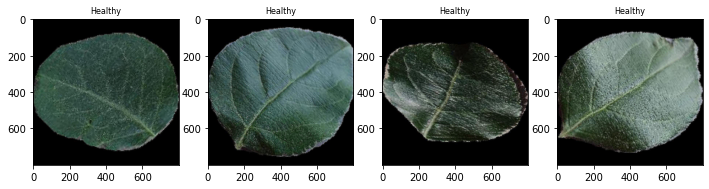

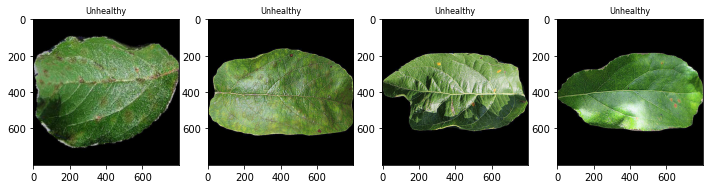

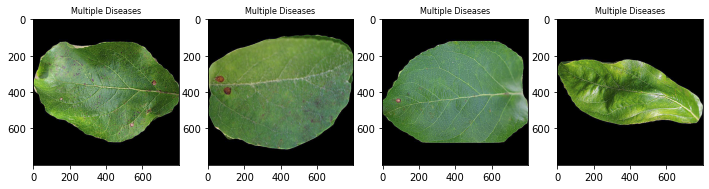

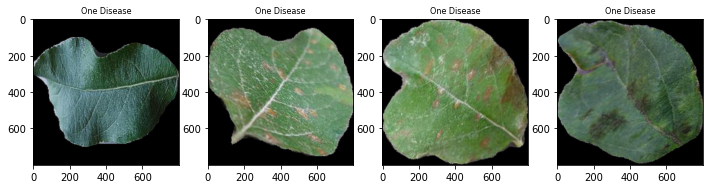

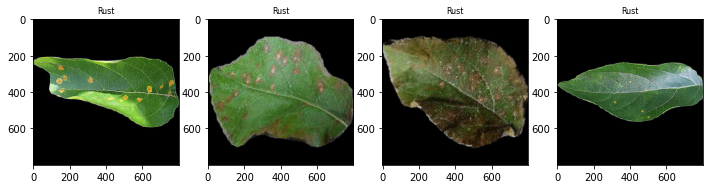

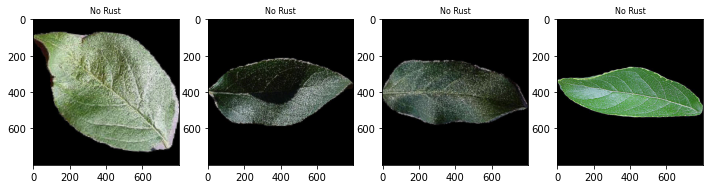

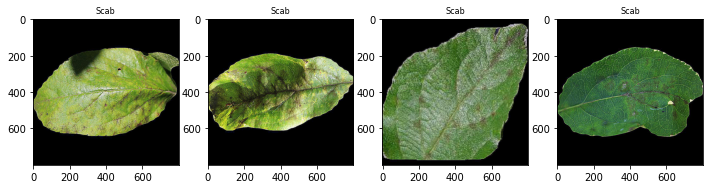

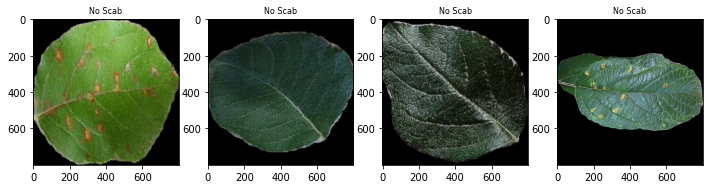

In [11]:
# Display some image samples of each category
for i, key in enumerate(samples):
    # create a (1x4) figure window
    fig, ax = plt.subplots(1, nsamples, figsize = (12, 8))

    for j in range(nsamples):
        # load the sample image
        img = cv2.imread(trainingImgsPath + samples[key].iloc[j]['image_id'] + ".jpg")

        #Do a bit of cleaning
        # convert the image from BGR to RGB format (opencv's default is BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create a shapening kernel and sharpen the image
        sharpening_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        img = cv2.filter2D(img, -1, sharpening_kernel)

        # show the image and add a title to the plot
        ax[j].imshow(img)
        ax[j].set_title(key, fontsize=8)
        ax[j].grid(False)

    plt.show()

Here we have a sample of all the apple leaf types. We can see from the set of images that there are some variations in leaf color, shape, texture, etc. We can also see that leaves with a type of sickness have spots of different colors and sizes depending on the nature of the disease. We may be able to use this to our advantage while building our classifier. 

Finally, let's take a look at how our samples are distributed. It is important to check this to see whether we may have unbalanced classes which could negatively affect training. Here, we will create a plot of all four classes together:

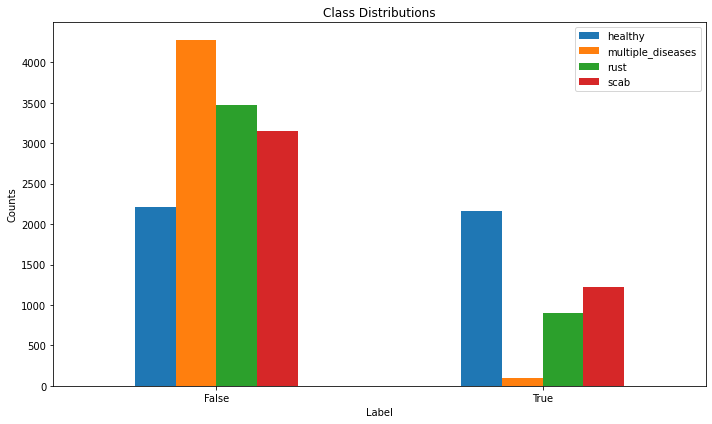

In [12]:
# show the distribution of the field categories
ax = trainingLabels[class_labels].apply(pd.value_counts).plot.bar(figsize=(10, 6)) 

# clean up the figure a bit
ax.set_title("Class Distributions")
ax.set_ylabel("Counts")
ax.set_xlabel("Label")
ax.set_xticklabels(["False", "True"], rotation=0)
plt.tight_layout()
plt.show()

Looking at the bar charts, we can see that the unhealthy vs healthy class is
well balanced, but the other classes (multiple_diseases, rust and scab) have a lot
more negative values than positive ones. 

### Build a Simple Image Descriptor


We will create a simple RGB histogram image descriptor. A color histogram can be used to count the number of times a specific pixel intensity occurs in an image. In this case, we will be doing this calculation for each channel in the image (Red-Green-Blue). So to put it simply, we will be calculating how many pixels of each color occur in a healthy plant image, and an unhealthy plant image. The counts for each color/color range will be used as our feature vector, which we will pass to our ML model. A graphical representation of a color histogram is given below.


<center> Example Representation of an RGB image histogram </center>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Odd-eyed_cat_histogram.png" />


<center>   
 By <a href="//commons.wikimedia.org/w/index.php?title=User:Muenteroman&amp;action=edit&amp;redlink=1" class="new" title="User:Muenteroman (page does not exist)">Muenteroman</a> - <span class="int-own-work" lang="en">Own work</span>, File:Odd-eyed cat by ihasb33r.jpg, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=43793434">Link</a>
</center>


Here, we will be constructing a 3D color histogram containing 8 bins per channel, which will produce feature vector of dims 8 x 8 x 8, or 512 when flattened. This is pretty handy, since the size of our original image is (800 x 800 pixels) x 3 channels or, 1 920 000 pixels. We are saving our computer a ton of memory space! If we had larger images (1920 x 1080 for example), it would be wise to reduce the image size to a more manageable dimension to increase the speed of the histogram computation.

In [13]:
# Create a class for constructing our image descriptor. We will pass this descriptor to our classification model.

class RGBHist:
    def __init__(self, bins):
        # specify the number of bins that we will need to build the histogram
        self.bins = bins

    def describe(self, image):
        # compute a 3D histogram for each image using the 3 color spaces (R, G, B)
        # in the image. Normalize the histogram to accomodate multiple image
        # sizes if that is the case.
        histogram = cv2.calcHist([image], [0, 1, 2], None, self.bins, [0, 256, 0, 256, 0, 256])
        cv2.normalize(histogram, histogram)

        # return out 3D histogram as a flattened array
        return histogram.flatten()

In [14]:
# initialize the image descriptor
desc = RGBHist([8, 8, 8])

Here we will loop through the images, describe them using our image descriptor,
and then pass the feature vectors to a Random Forest Classifier. Let's give this a go!

In [15]:
# Function to help construct our training matrix
def create_training_data(trainingImgsPath, trainingLablsPath, descriptor):
    # create an empty list to store the images and labels
    trainingfeatures = []

    # sort the image paths so that they are matched with the correct label
    imagePaths = sorted(list(paths.list_images(trainingImgsPath)))

    # loop through the images and load them to disk
    for image in imagePaths:
        if "Test" in image: 
            pass
        else:
            img = cv2.imread(image)

            # convert the image from BGR to RGB format (opencv's default is BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # describe the image
            features = descriptor.describe(img)

            # update the list of features
            trainingfeatures.append(features)

    # load the training labels and only keep the 1st category
    trainingLabels = pd.read_csv(trainingLablsPath)
    trainingLabels = trainingLabels[["healthy"]].to_numpy().astype("uint8")

    return (trainingfeatures, trainingLabels)

### Train the model
In this next step, we will load the images one by one, convert them to RGB histograms, and create a final training matrix to train the model with. 

In [16]:
(X_train, y_train) = create_training_data(trainingImgsPath, trainingLablsPath, desc)

Next, we create a train/test split and train our model. We are putting aside a chunk of our data (25%) to use for evaluating it's performance. 

In [17]:
# construct the training and testing splits
(trainData, testData, trainTarget, testTarget) = train_test_split(X_train, y_train,
	test_size=0.25, random_state=42, shuffle = True)

print("Length of training data: ", len(trainData))
print("Length of validation data: ", len(testData))

Length of training data:  3278
Length of validation data:  1093


In [18]:
# train the classifier
model = RandomForestClassifier(n_estimators=25, random_state=84)
model.fit(trainData, trainTarget.ravel())
target_names = ['unhealthy', 'healthy']

### Evaluate the model 
The last step is checking to see how well our model did. We can use some handy functions from scikit-learn to do this pretty easily! 

In [19]:
# evaluate the classifier
print(classification_report(testTarget, model.predict(testData),
	target_names = target_names))

              precision    recall  f1-score   support

   unhealthy       0.79      0.92      0.85       572
     healthy       0.90      0.72      0.80       521

    accuracy                           0.83      1093
   macro avg       0.84      0.82      0.83      1093
weighted avg       0.84      0.83      0.83      1093



In [20]:
# show the confusion matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(testTarget, model.predict(testData))

array([[529,  43],
       [144, 377]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

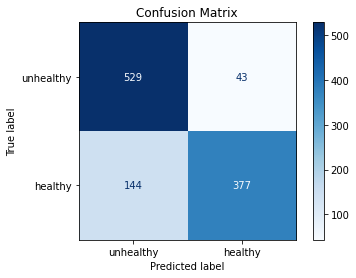

In [21]:
disp = plot_confusion_matrix(model, testData, testTarget,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues, values_format =".0f")
disp.ax_.set_title("Confusion Matrix")


Even with a simple RGB descriptor and Random Forest classifier, we were able to produce a model with an accuracy of 83%! Not bad. Let's put you to the test. Try and come up with another type of ML model (SVM, neural network, etc.) and other image manipulations that might improve your results. You can even test your performance by running it on the test set at the very end, and entering a late submission in the competition. Have fun! :) 